<a href="https://colab.research.google.com/github/Keeron1/com.mcast.research_design_I_2025.spiteri_keeron/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Packages

In [ ]:
# Install PyTorch, OpenCV, Ultralytrics, Roboflow, matplot and scikit
!pip install torch torchvision opencv-python ultralytics roboflow matplotlib scikit-learn

# Clone DeepSORT and YOLO model from Git
!git clone -n --depth=1 --filter=tree:0 \
  https://github.com/Keeron1/com.mcast.research_design_I_2025.spiteri_keeron.git
%cd /content/com.mcast.research_design_I_2025.spiteri_keeron
!git sparse-checkout set --no-cone src/deep_sort_pytorch src/yolo
!git checkout
# Copy folders
!rsync -av --remove-source-files src/deep_sort_pytorch/ ../deep_sort_pytorch/
!rsync -av --remove-source-files src/yolo/ ../yolo/
%cd ..
!rm -rf com.mcast.research_design_I_2025.spiteri_keeron # Delete repo directory

!pip install -r deep_sort_pytorch/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.

# 2. Import Libraries

In [ ]:
from google.colab.patches import cv2_imshow # cv2.imshow("title", frane) doesn't work in Colab so this is the fix cv2_imshow(frame)
from IPython.display import HTML, Video, display
from base64 import b64encode
from ultralytics import YOLO
import cv2
import glob
import json
import os
import re

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# 3. Dataset

## 4.1 Download

In [ ]:
# dataset_download_path = "/content/pedestrain-data.zip"
# dataset_path = "/content/dataset"

from roboflow import Roboflow
rf = Roboflow(api_key="Lk4WqTpXqRQy6k3fUroX")
project = rf.workspace("workspace-xqop9").project("student-activity-jymic")
version = project.version(5) # v3TestVal v4TrainingTestVal v5 testing

dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Student-Activity-5 in yolov8:: 100%|██████████| 402/402 [00:00<00:00, 2220.34it/s]


## 4.2 Unzip
To be used when a .zip dataset is downloaded

In [ ]:
!unzip -q {dataset_download_path} -d {dataset_path}
!rm -rf {dataset_download_path}

# 4. Config

## 4.1 Main Config

In [ ]:
# File paths used in the program
dataset_data_path = dataset.location + "/data.yaml"
idx_to_class_path = "/content/idx_to_class.json"
output_video_path = "/content/output.mp4"

# Load object detector model
model = YOLO("/content/yolo/best.pt")
# model = YOLO("yolov8s") # Used as training weights
model.info() # Display model information

# DeepSORT cfg
deep_sort_cfg = {
    "USE_FASTREID" : False,
    'DEEPSORT': {
        'REID_CKPT': 'deep_sort_pytorch/deep_sort/deep/checkpoint/ckpt.t7', # ckpt.t7 are the weights that were used in the research paper
        'MAX_DIST': 0.2, # Maximum cosine distance
        'MIN_CONFIDENCE': 0.5, # 0.8 Minimum detector confidence
        'NMS_MAX_OVERLAP': 1, # 1 Maximum IoU for suppressing overlapping boxes.
        'MAX_IOU_DISTANCE': 0.7, # 0.7 Max IoU distance for motion-only matching in the cascade.
        'MAX_AGE': 30, # 70 Number of consecutive frames a track is kept “alive” without matching.
        'N_INIT': 3, # Number of frames a track must be consistently matched before confirmed.
        'NN_BUDGET': 100 # Maximum number of appearance features to store per track.
    }
}

Model summary: 129 layers, 11,137,148 parameters, 0 gradients, 28.7 GFLOPs


## 4.2 Generate idx_to_class & target_class_ids

In [ ]:
from deep_sort_pytorch.utils.tools import generate_idx_to_class
# Import idx_to_class file
if os.path.isfile(idx_to_class_path):
  with open(idx_to_class_path, 'r') as f:
    idx_to_class = json.load(f)
else:
  idx_to_class = generate_idx_to_class(dataset_data_path)

# Get the pre-trained YOLO's class indices for the targetted classes
target_classes = set(idx_to_class.values())
target_class_ids = [i # build array
                    for i,c in model.names.items()  # loop through model names
                    if c in target_classes] # if model name exists in target class list

# 5. Functions

## 5.1 Play Video

In [ ]:
def play_video(video_path):
  video_info = video_path.rsplit('.')
  compressed_video_path = f"{video_info[0]}_compressed.mp4"

  if video_info[1] == "avi": # convert to mp4 from avi
    os.system(f"ffmpeg -i {video_path} -c:v libx264 -crf 20 -preset slow -pix_fmt yuv420p {video_info[0]}.mp4")

  # compress video file (cant run in colab without compressing)
  os.system(f"ffmpeg -i {video_info[0]}.mp4 -vcodec libx264 {compressed_video_path}")

  display(Video(compressed_video_path, embed=True, width=640))

# 6. Train Model

## 6.1 Train
Normalizing Pixel Values: YOLOv8 automatically normalizes pixel values to a range of 0 to 1 during preprocessing, so it's not required.

In [ ]:
results = model.train(data=dataset_data_path,
                      epochs=100,
                      batch=32,
                      imgsz=640)

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Student-Activity-4/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, 

100%|██████████| 755k/755k [00:00<00:00, 22.7MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    591360  ultralytics.nn.modules.block.C2f             [768, 256, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 16                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256,

100%|██████████| 5.35M/5.35M [00:00<00:00, 81.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1227.6±359.3 MB/s, size: 44.0 KB)


train: Scanning /content/Student-Activity-4/train/labels... 414 images, 0 backgrounds, 0 corrupt: 100%|██████████| 414/414 [00:00<00:00, 1911.10it/s]

train: New cache created: /content/Student-Activity-4/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 962.3±528.3 MB/s, size: 45.0 KB)


val: Scanning /content/Student-Activity-4/valid/labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 1683.18it/s]

val: New cache created: /content/Student-Activity-4/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.14G      1.456      2.733      1.281        717        640: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                   all         30        469       0.73      0.686      0.699      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.86G      1.083     0.7302      1.063        575        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         30        469      0.863      0.744      0.762      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       7.2G     0.9334     0.5873      1.008        707        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         30        469      0.766       0.67      0.695      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.24G     0.8625     0.5197     0.9691        707        640: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         30        469       0.74      0.671      0.762      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.28G     0.8113     0.5017     0.9591        586        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         30        469      0.759      0.766      0.821      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.31G     0.8042     0.4807     0.9638        779        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         30        469      0.901      0.851      0.884      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.35G     0.7878     0.4716     0.9465        705        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         30        469      0.925      0.856      0.879      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.38G     0.7684     0.4518     0.9423        588        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         30        469      0.869      0.825      0.846      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.09G     0.7898     0.4606     0.9469        662        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         30        469      0.874      0.809      0.855      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.17G     0.7348     0.4376      0.939        592        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         30        469      0.869      0.907      0.926      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.87G     0.7374       0.45     0.9353        726        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         30        469      0.948      0.884      0.914       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.21G     0.7414     0.4395     0.9335        653        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         30        469      0.807      0.779      0.814      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.25G     0.7694     0.4401     0.9453        664        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         30        469      0.833      0.773      0.829      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.29G     0.7359     0.4216     0.9364        672        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         30        469      0.886      0.875       0.88      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.32G     0.7134     0.4167     0.9305        555        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         30        469      0.908      0.901      0.921      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.36G     0.7061     0.4166     0.9224        630        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         30        469      0.868      0.805      0.874      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.39G     0.7155     0.4136     0.9198        607        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         30        469      0.924      0.941      0.932      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.44G     0.7102     0.3978     0.9244        671        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         30        469      0.894      0.849      0.872      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.94G     0.7232     0.4044      0.927        587        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         30        469      0.808      0.834      0.853      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.28G     0.6946     0.4032     0.9206        666        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         30        469      0.933      0.843      0.913      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.31G     0.6883     0.3964     0.9156        683        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         30        469      0.924      0.821      0.901       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.35G     0.6554     0.3809     0.9093        617        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         30        469      0.901      0.914      0.913      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.39G     0.6519     0.3885     0.9066        634        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         30        469      0.922      0.908      0.927      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.35G     0.6451     0.3798        0.9        667        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         30        469      0.939      0.936      0.935      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.85G     0.6274     0.3716     0.8977        676        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         30        469      0.906      0.906      0.901      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.19G     0.6463      0.381     0.9072        728        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         30        469      0.948      0.899       0.91      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.55G     0.6338     0.3678     0.9061        575        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         30        469      0.915       0.92      0.914      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.58G     0.6317      0.369     0.8969        746        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         30        469      0.949      0.938      0.945      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.89G     0.6326     0.3666     0.9003        686        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         30        469      0.894       0.91      0.938      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.23G     0.6373     0.3641     0.8949        752        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         30        469      0.888       0.91      0.948       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.27G     0.6148     0.3539     0.8937        824        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         30        469      0.935      0.919      0.937      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       7.3G     0.5909     0.3618     0.8871        685        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         30        469       0.96      0.872      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.34G       0.61     0.3655     0.8962        589        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         30        469      0.905      0.861      0.895      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.38G     0.5861     0.3404     0.8775        708        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         30        469      0.922      0.937      0.919      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.53G     0.5949     0.3551       0.89        648        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         30        469      0.949      0.921      0.925      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.35G     0.6112     0.3611     0.8898        638        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         30        469      0.897      0.899       0.91       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.85G     0.5844     0.3569     0.8823        576        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         30        469      0.948       0.91      0.931      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.19G     0.6005     0.3478     0.8922        676        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         30        469      0.951      0.917      0.943      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.23G     0.6037     0.3486     0.8895        749        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         30        469      0.938       0.91       0.91      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.26G     0.5877     0.3515     0.8871        539        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         30        469      0.964      0.947       0.95      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       7.3G     0.5797     0.3399     0.8828        633        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         30        469      0.964      0.939      0.952      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.33G     0.5746     0.3398      0.877        723        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         30        469      0.952      0.926      0.946      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.37G     0.5667     0.3343     0.8852        661        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         30        469      0.969      0.944      0.965       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.31G     0.5666     0.3338     0.8756        706        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         30        469      0.977      0.953      0.966      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.04G     0.5522     0.3227     0.8706        647        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         30        469      0.979      0.953      0.966      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.38G     0.5697     0.3332     0.8841        828        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         30        469       0.96      0.957      0.957      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.89G     0.5515     0.3236     0.8744        645        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         30        469      0.962      0.949      0.957      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.23G     0.5585     0.3244      0.876        560        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         30        469       0.96      0.934      0.945      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.27G     0.5815      0.328     0.8836        677        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         30        469      0.919      0.897      0.948      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       7.3G     0.5575     0.3205     0.8748        669        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         30        469      0.903      0.916      0.939      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.34G     0.5557     0.3231      0.873        592        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         30        469      0.906      0.932      0.941      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.38G     0.5484     0.3226     0.8734        598        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         30        469      0.923      0.906      0.934      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.16G     0.5344     0.3097     0.8703        871        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         30        469       0.94      0.922      0.934      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.17G     0.5467     0.3299     0.8735        755        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         30        469      0.949      0.901      0.926      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       6.9G     0.5385     0.3238     0.8679        663        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         30        469      0.919      0.936      0.933      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.24G     0.5404     0.3174     0.8708        672        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         30        469      0.931      0.942       0.95      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.27G     0.5365     0.3109     0.8702        637        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30        469      0.921      0.895      0.945      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.31G     0.5308     0.3163      0.866        609        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         30        469       0.94      0.897      0.937      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.35G     0.5166     0.2969     0.8622        627        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         30        469      0.915      0.873      0.943      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.38G     0.5207     0.2995     0.8654        613        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         30        469       0.95      0.887      0.926      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.28G      0.519     0.3116     0.8668        704        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         30        469       0.96      0.886      0.935      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.01G     0.5115     0.3004      0.861        573        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         30        469      0.963      0.857      0.934      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.33G      0.509      0.297     0.8639        691        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         30        469      0.971      0.892      0.959      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.37G     0.5187     0.2989     0.8652        663        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         30        469      0.971       0.91      0.958      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.43G      0.506     0.2976     0.8654        807        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         30        469      0.951      0.922      0.946      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       7.2G     0.5026     0.2956     0.8601        562        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         30        469      0.921      0.924      0.944      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.86G     0.5135     0.2954     0.8629        725        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         30        469      0.963      0.919      0.953      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       7.2G     0.4907     0.2896     0.8563        721        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         30        469      0.959       0.93      0.955      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.23G     0.5009     0.2896      0.859        714        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         30        469      0.956      0.907      0.948      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.27G     0.5013     0.2953     0.8608        624        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         30        469      0.959      0.904       0.95      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.31G     0.5044     0.2932      0.858        636        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         30        469      0.958       0.93      0.953      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.34G     0.4975     0.2938     0.8592        726        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         30        469      0.959      0.936      0.955      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.38G     0.4923     0.2877     0.8582        594        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         30        469      0.954      0.943      0.955      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.46G     0.4854     0.2852     0.8554        798        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         30        469      0.953      0.903       0.94      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.91G     0.4912     0.2868     0.8601        628        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         30        469      0.955        0.9      0.949      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.25G     0.4954     0.2887     0.8568        593        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         30        469      0.957      0.913       0.94      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.28G     0.4824      0.289     0.8566        556        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         30        469      0.962      0.916       0.95      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.32G     0.4727     0.2798     0.8512        684        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         30        469      0.928      0.941      0.945      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.36G     0.4848     0.2794     0.8567        708        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         30        469      0.964      0.904      0.951      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.29G     0.4687     0.2734     0.8459        772        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         30        469      0.951      0.929      0.948      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.95G     0.4657     0.2754      0.852        553        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         30        469      0.953      0.917      0.942      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.29G     0.4649     0.2761     0.8482        726        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         30        469      0.971      0.905      0.956      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.32G     0.4742     0.2886     0.8556        811        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         30        469      0.962      0.898      0.947      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.36G     0.4629     0.2821     0.8492        682        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         30        469      0.959      0.897      0.949      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.39G      0.467     0.2761     0.8504        596        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         30        469      0.962      0.899      0.946      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.34G     0.4616     0.2802      0.848        727        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         30        469      0.953      0.915      0.944      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.93G     0.4592     0.2654     0.8477        683        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         30        469       0.96      0.925      0.953      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.27G     0.4526     0.2663     0.8465        626        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         30        469      0.959      0.913      0.944      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.31G     0.4526     0.2687      0.851        646        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         30        469      0.966      0.904      0.942      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.34G      0.452     0.2685     0.8482        668        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         30        469      0.956      0.923      0.946      0.624


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.38G     0.4334     0.2451     0.8303        437        640: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         30        469      0.961      0.913       0.94      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.35G     0.4324     0.2428     0.8282        438        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         30        469      0.955      0.909      0.932      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.84G     0.4261     0.2443     0.8345        473        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         30        469      0.959      0.919      0.944       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.18G     0.4193     0.2399     0.8266        417        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         30        469      0.954      0.936      0.951      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.22G     0.4148     0.2375     0.8287        456        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         30        469      0.957      0.932      0.951       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.26G     0.4153     0.2364      0.824        465        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         30        469      0.959      0.917      0.943      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.29G     0.4096     0.2319      0.822        430        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         30        469      0.968      0.921      0.948      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.33G     0.4075      0.231     0.8247        469        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         30        469      0.964      0.918      0.945      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.37G     0.4015     0.2297     0.8265        439        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         30        469      0.961      0.917      0.941       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.29G     0.3995     0.2285     0.8236        453        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         30        469      0.959      0.915      0.942      0.632



100 epochs completed in 0.240 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


                   all         30        469      0.971       0.91      0.958       0.64
                  book         30         35      0.975          1      0.995      0.648
                person         30        242      0.998          1      0.995      0.889
                 phone         30        192      0.939      0.729      0.883      0.385
Speed: 0.3ms preprocess, 4.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


# 7. Test Model

In [ ]:
# model = YOLO("runs/detect/train/weights/best.pt")

# Run inference with the YOLO model on the validation dataset
# , classes=target_class_ids
results = model.predict(source=f"{dataset.location}/test/images", save=True, verbose=True)


image 1/30 /content/Student-Activity-4/test/images/00000004_jpg.rf.4f905e2c639cb7ebb9254cdb8095dd99.jpg: 640x640 1 book, 8 persons, 7 phones, 16.2ms
image 2/30 /content/Student-Activity-4/test/images/00000005_jpg.rf.9ce9df12190a610d9e9733545bff9b18.jpg: 640x640 1 book, 8 persons, 7 phones, 16.3ms
image 3/30 /content/Student-Activity-4/test/images/00000018_jpg.rf.689222573bf272b6c6925b960ac03b7d.jpg: 640x640 2 books, 8 persons, 6 phones, 16.2ms
image 4/30 /content/Student-Activity-4/test/images/00000021_jpg.rf.3ca470b956cb56e57c2be01d1932e087.jpg: 640x640 1 book, 8 persons, 6 phones, 16.2ms
image 5/30 /content/Student-Activity-4/test/images/00000024_jpg.rf.256588acc51d4b074d7e4d67616a1b1b.jpg: 640x640 1 book, 8 persons, 6 phones, 16.2ms
image 6/30 /content/Student-Activity-4/test/images/00000031_jpg.rf.68dacb9dd0111cdc8fe1852cdddd1bea.jpg: 640x640 1 book, 8 persons, 6 phones, 26.7ms
image 7/30 /content/Student-Activity-4/test/images/00000032_jpg.rf.63df06b9def2db98bdc7d1ccd389c2c8.jpg:

## 7.1 Display Results

### 7.1.1 Play Results Video

In [ ]:
dirs = []
base_dir = "/content/runs/detect"
# List all directories in the base directory
for predictFolder in os.listdir(base_dir):
  if os.path.isdir(os.path.join(base_dir, predictFolder)):
    if predictFolder.startswith('train'): # folder is called predict or train
      # If the directory has a number then extract it else append 0
      m = re.search(r"(\d+)$", predictFolder)
      num = int(m.group(1)) if m else 0
      dirs.append((predictFolder, num)) # each item contains the folder name and its number

played_video = False

if dirs:
  dirs.sort(key=lambda x: x[1], reverse=True) # Sort by number in reverse (largest)
  latest_pred_dir = dirs[0][0]
  latest_pred_dir_path = os.path.join(base_dir, latest_pred_dir)

  for f in os.listdir(latest_pred_dir_path):
    if f.endswith('.avi'):
      results_video_path = os.path.join(latest_pred_dir_path, f)
      played_video = True
      play_video(results_video_path)
      break

  if not played_video: # Convert images to video
    os.system(f"ffmpeg -framerate 5 -pattern_type glob -i '{latest_pred_dir_path}/*.jpg' -c:v libx264 -pix_fmt yuv420p predict_results.mp4")
    play_video("predict_results.mp4")


### 7.1.2 From predict function

In [ ]:
# Process results list
for result in results[:10]:
    boxes = result.boxes  # Boxes object for bounding box outputs
    # print(boxes.data.tolist()) # x1, y1, x2, y2, conf score, class id
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    # result.save(filename="result.jpg")  # save to disk

### 7.1.3 From predict folder

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob("runs/detect/predict/*.jpg")[:10]:
  display(Image(filename=image_path, height=400))
  print("\n")

# 8. Run Model

## 8.1 Initalize DeepSORT
Create the Tracker

In [ ]:
from deep_sort_pytorch.deepsort import DeepSortTracker
from deep_sort_pytorch.utils.parser import get_config
from deep_sort_pytorch.utils.draw import draw_boxes, compute_color_for_labels

# Pass the config
cfg = get_config() # Create new empty dict
cfg.merge_from_dict(deep_sort_cfg) # merge dict

# Initialize DeepSORT tracker
deep_sort_tracker = DeepSortTracker(cfg, use_cuda=True)

## 8.2 Initalize Activity Recognizer

In [ ]:
activities_iooA_threshold = 0.5 # 50% of the object has to be in the person's bbox
activities_priority = {
  "phone": 3,
  "laptop": 2,
  "book": 1
}
activities_map = {
    "phone": "using_phone",
    "book": "using_book",
    "laptop": "using_laptop"
}
no_activity = "no_activity"

### 8.2.1 Activity Functions

#### 8.2.1.1 draw_boxes_activity

In [ ]:
def draw_boxes_activity(frame, bboxes, names, identities=None, activities=None):
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 0.5
  thickness = 1
  for i, box in enumerate(bboxes):
    x1, y1, x2, y2 = [int(i) for i in box] # bbox coords
    track_id = int(identities[i]) if identities is not None else 0
    label_color = compute_color_for_labels(track_id)

    # Format label
    label = f'{names[i]} '
    if not identities is None:
      label += f'{track_id}'
    if not activities is None:
      if track_id in activities:
        label += f'{activities[track_id]}'


    # Draw rectangle
    cv2.rectangle(frame, (x1, y1), (x2, y2), label_color, 2)

    # Draw label background
    (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, thickness)
    cv2.rectangle(frame, (x1, y1 - text_height - 6), (x1 + text_width, y1), label_color, -1)

    # Draw label text
    cv2.putText(frame, label, (x1, y1 - 4), font, font_scale, (255, 255, 255), thickness)

  return frame

#### 8.2.1.2 get_ioOA
IoOA is calculated by dividing the area of the inner object by the intersection area.

In [ ]:
def get_ioOA(innerbbox, outerbbox):
  # Get bbox coords
  ix1, iy1, ix2, iy2 = [int(i) for i in innerbbox]
  ox1, oy1, ox2, oy2 = [int(i) for i in outerbbox]
  # top-left (1) and bottom right (2)

  # Determine the intersection box coords
  # Get the largest coordinates from the top left of the bboxes
  x1 = max(ix1, ox1)
  y1 = max(iy1, oy1)
  # Get the smallest coordinates from the bottom right of the bboxes
  x2 = min(ix2, ox2)
  y2 = min(iy2, oy2)

  # Get the width and height of the intersection box
  interWidth = max(0, x2 - x1) # Subtracting the bottom right by the top left to get the width
  interHeight = max(0, y2 - y1)

  # Get the area of the intersection box
  interArea = interWidth * interHeight

  # Get the area of the bboxes
  innerBoxArea = (ix2 - ix1) * (iy2 - iy1) # Get the width and height of the bbox then multiply with each other

  # Return the Intersection over Object Area
  if interArea == 0: # Checking if is divisible
    return 0
  ioOA = interArea / innerBoxArea
  return ioOA

#### 8.2.1.3 recognize_activity

In [ ]:
def recognize_activity(outputs):
  activities = {} # key: track_id, value: activity label

  person_outputs = []
  object_outputs = []

  bbox_xyxy = outputs[:, :4] # Bounding Boxes
  identities = outputs[:, -1] # Unique Track IDs
  cls = outputs[:, -2] # Classes (ids)
  labels = [model.names[id] for id in cls] # Class names

  # Loop through detected bboxes
  for i, bbox in enumerate(bbox_xyxy):
    track_id = int(identities[i]) if identities is not None else 0
    label = labels[i] # bbox label

    # Categorize object in appropriate array
    if label == "person":
      person_outputs.append((track_id, bbox))
    elif label in {"phone", "book", "laptop"}:
      object_outputs.append((label, bbox))

  # Check for activity
  for person_track_id, person_bbox in person_outputs:
    potentialActivities = {}
    for obj_label, obj_bbox in object_outputs:
      # Checking if object is inside person bbox
      iooA = get_ioOA(obj_bbox, person_bbox)
      if iooA >= activities_iooA_threshold:
        # Add potential activity
        potentialActivities[obj_label] = iooA

    # Check if there were any potential activities detected
    if not potentialActivities:
      activities[person_track_id] = no_activity
      continue

    # Activity prioritiy
    activity = False
    activityScore = -1
    for activity, iou in potentialActivities.items():
      score = activities_priority[activity]
      if score > activityScore:
        activityScore = score
        activity = activity

    if activity:
      activities[person_track_id] = activities_map[activity]

  return activities

#### 8.2.1.4 get_iou
IoU is calculated by dividing the area of the intersection boxes by the union area of the boxes.

In [ ]:
def get_iou(innerbbox, outerbbox):
  # Get bbox coords
  ix1, iy1, ix2, iy2 = [int(i) for i in innerbbox]
  ox1, oy1, ox2, oy2 = [int(i) for i in outerbbox]
  # top-left (1) and bottom right (2)

  # Determine the intersection box coords
  # Get the largest coordinates from the top left of the bboxes
  x1 = max(ix1, ox1)
  y1 = max(iy1, oy1)
  # Get the smallest coordinates from the bottom right of the bboxes
  x2 = min(ix2, ox2)
  y2 = min(iy2, oy2)

  # Get the width and height of the intersection box
  interWidth = max(0, x2 - x1) # Subtracting the bottom right by the top left to get the width
  interHeight = max(0, y2 - y1)

  # Get the area of the intersection box
  interArea = interWidth * interHeight

  # Get the area of the bboxes
  innerBoxArea = (ix2 - ix1) * (iy2 - iy1) # Get the width and height of the bbox then multiply with each other
  outerBoxArea = (ox2 - ox1) * (oy2 - oy1)

  # Calculate the union area
  unionArea = (innerBoxArea + outerBoxArea) - interArea
  # union is the area of both boxes combined, minus the area that intersects between both boxes

  # Checking if is divisible
  if unionArea == 0:
      return 0

  # Return the IoU
  return interArea / unionArea

## 8.3 Main Function
Peforms object detection, tracking, activity recognition and draws the results on the frame passed through argument, returns the same frame with drawings.

In [ ]:
# If this calls a TypeError: cannot unpack non-iterable NoneType object
# Make some comments in the function and it somehows fixes it
def run_main(frame):
  if frame is None:
    return None

  # Perform object detection , classes=target_class_ids
  results = model.predict(source=frame, verbose=False)
  # print("1")
  # Prepare detections for DeepSORT
  bbox_xywh = results[0].boxes.xywh.cpu().numpy()
  conf = results[0].boxes.conf.cpu().numpy()
  cls_ids = results[0].boxes.cls.cpu().numpy()

  # Update DeepSORT tracker
  outputs,_ = deep_sort_tracker.update(bbox_xywh, conf, cls_ids, frame) #outputs bbox, track id, class
  # print("2")
  # Check if results is empty
  if len(outputs) > 0:
    bbox_xyxy = outputs[:, :4] # Bounding Boxes
    identities = outputs[:, -1] # Unique Track IDs
    cls = outputs[:, -2] # Classes

    # Get class names
    try:
      names = [model.names[id] for id in cls] # idx_to_class
    except KeyError as e:
      missing_id = e.args[0]
      raise ValueError(f"Class id '{missing_id}' not found in model data.")

    # Activity Recognition
    activities = recognize_activity(outputs)
    if not activities:
      print("No activities detected!")
    # print("3")
    # Draw the results
    processed_frame = draw_boxes_activity(frame, bbox_xyxy, names, identities, activities)

    # Draw bounding boxes
    # processed_frame = draw_boxes(frame, bbox_xyxy, names, identities)
    # print("4")
    return processed_frame, outputs, activities
  return None

## 8.4 Run

### 8.4.1 Images

In [ ]:
# Config
save_video = True # Creates a video from all the frames
play_frames = False # Plays the frames while processing
frames_path = sorted(glob.glob(dataset.location + "/test/images/*.jpg"))

# Validating the frames path
if not frames_path:
    raise RuntimeError("No frames found")

# Retrieve first frame dimensions
if save_video:
  first_frame = cv2.imread(frames_path[0])
  height, width = first_frame.shape[:2]
  fps = 5

  # Define the codec and create VideoWriter
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files
  out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Loop through images/frames
for img_path in frames_path:

  # Read the frame
  frame = cv2.imread(img_path)
  if frame is None:
    continue

  # Process the frame
  processed_frame,_,_1 = run_main(frame)
  if processed_frame is None:
    continue

  if save_video: out.write(processed_frame) # Write current frame to output
  if play_frames: cv2_imshow(processed_frame) # output current frame

  # if cv2.waitKey(1) & 0xFF == ord('q'):
    # break

# Release resources
if save_video: out.release()
# cv2.destroyAllWindows()

1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3


### 8.4.2 Video

In [ ]:
# Config
save_video = True # Creates a video from all the frames
play_frames = False # Plays the frames while processing

cap = cv2.VideoCapture("/content/people.mp4") # Load video

ret, frame = cap.read() # Read first frame

# Retrieve frame dimensions and frames per second (fps)
if save_video:
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = cap.get(cv2.CAP_PROP_FPS)
  # Define the codec and create VideoWriter
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files
  out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

while ret:
  # Process the frame
  processed_frame,_,_1 = run_main(frame)
  if processed_frame is None:
    continue

  if save_video: out.write(processed_frame) # Write current frame to output
  if play_frames: cv2_imshow(processed_frame) # output current frame

  # Read next frame
  ret, frame = cap.read()

  # if cv2.waitKey(1) & 0xFF == ord('q'):
  #   break

# Release resources
cap.release()
if save_video: out.release()
# cv2.destroyAllWindows()

## 8.5 Play Output Video

In [ ]:
play_video(output_video_path)

## Results

### Generate ground-truth activity
This script simulates the activity recognition by checking for overlapping activity object bboxes. It is not that accurate.

In [ ]:
import os
from pathlib import Path

def yolo_to_bbox(line, img_width, img_height):
    class_id, x, y, w, h = map(float, line.strip().split())
    x1 = (x - w/2) * img_width
    y1 = (y - h/2) * img_height
    x2 = (x + w/2) * img_width
    y2 = (y + h/2) * img_height
    return int(class_id), (x1, y1, x2, y2), (x, y, w, h)

def infer_activities(annotation_path, img_width, img_height):
  class_to_id = {v: k for k, v in model.names.items()}

  with open(annotation_path) as f:
      lines = f.readlines()

  # Read the bboxes in the frame
  persons = []
  objects = []
  for line in lines:
    class_id, box_xyxy, box_yolo = yolo_to_bbox(line, img_width, img_height)
    if class_id == class_to_id["person"]:
      persons.append((box_xyxy, box_yolo))  # (XYXY, YOLO) format
    else:
      objects.append((class_id, box_xyxy))

  # Get activities
  activity_labels = []
  for person_box_xyxy, person_yolo_box in persons:
    potentialActivities = {}
    for class_id, object_box in objects:
      iooA = get_ioOA(object_box, person_box_xyxy)
      if iooA >= activities_iooA_threshold:
        potentialActivities[class_id] = iooA

    # Get the coordinates of the bbox
    x, y, w, h = person_yolo_box

    # Check if there were any potential activities detected
    if not potentialActivities:
      activity_labels.append(f"{class_to_id['person']} {x} {y} {w} {h} {no_activity}")
      continue

    # Activity prioritiy
    activity_classId = -1
    activityScore = -1
    for classId, _ in potentialActivities.items():
      label = model.names[classId] # Class names
      score = activities_priority[label]
      if score > activityScore:
        activityScore = score
        activity_classId = classId

    # Append the activity
    if activityScore >= 1:
      if activity_classId in model.names:
        # Get activity label
        activity = activities_map[model.names[activity_classId]]
        if activity:
          activity_labels.append(f"{class_to_id['person']} {x} {y} {w} {h} {activity}")

  return activity_labels # holds the class id, yolo box and activity

output_dir = Path(dataset.location + "/test/activity_results")
output_dir.mkdir(exist_ok=True)

# Loop all dataset files
for file in sorted(Path(dataset.location + "/test/labels/").glob("*.txt")):
  # Check frame
  acts = infer_activities(file, 640, 640)

  # write to file
  output_path = output_dir / file.name
  with open(output_path, 'w') as out_file:
    for output in acts:
      out_file.write(output + "\n")

### Plot Confusion Matrix

Collected 1646 valid ground truth/prediction pairs.
Confusion Matrix:


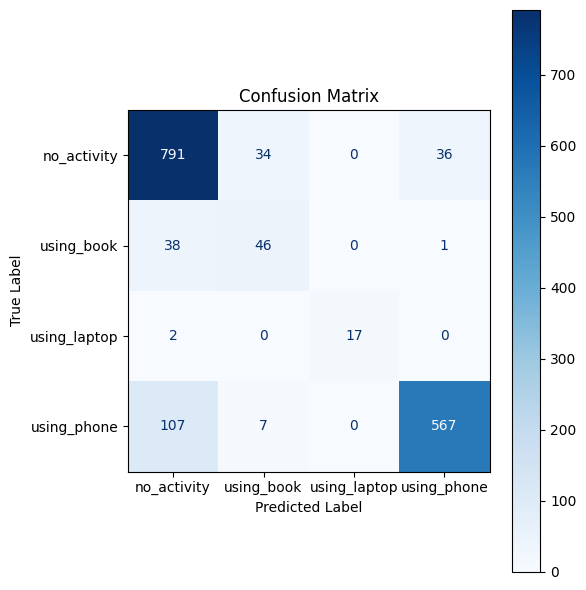


Classification Report:
              precision    recall  f1-score   support

 no_activity       0.84      0.92      0.88       861
  using_book       0.53      0.54      0.53        85
using_laptop       1.00      0.89      0.94        19
 using_phone       0.94      0.83      0.88       681

    accuracy                           0.86      1646
   macro avg       0.83      0.80      0.81      1646
weighted avg       0.87      0.86      0.86      1646



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
from pathlib import Path

gt_dir = Path(dataset.location + "/test/activity_results/")
pred_dir = Path(dataset.location + "/test/images/")

y_true = []
y_pred = []

# Loop through the ground truth data of the frames
for gt_file in sorted(gt_dir.glob("*.txt")):

  gt_labels = []
  gt_bboxes = []
  # Open the files and read their lines
  with open(gt_file) as f_gt:
    gt_lines = f_gt.readlines()
    # Loop through ground truth file lines
    for gt_line in gt_lines:
      # Extract the label and bbox coords from the line
      lineParts = gt_line.strip().split()
      gt_label = lineParts[-1]
      class_id, cx, cy, bw, bh = map(float, lineParts[:5])

      # Convert normalized YOLO to absolute Pascal VOC using image size
      cx *= 640
      cy *= 640
      bw *= 640
      bh *= 640

      x1 = int(cx - bw / 2)
      y1 = int(cy - bh / 2)
      x2 = int(cx + bw / 2)
      y2 = int(cy + bh / 2)

      # Append the label and bbox coords
      gt_labels.append(gt_label)
      gt_bboxes.append([x1, y1, x2, y2])

  # Run inference on frame
  pred_frame_path = (pred_dir / gt_file.name).with_suffix('.jpg') # Build file path

  # Read the frame
  pred_frame = cv2.imread(pred_frame_path)
  if pred_frame is None:
    print(f"Failed to read image: {pred_frame_path}")
    continue

  _,outputs,pred_activities = run_main(pred_frame)
  if len(outputs) <= 0:
    print(f"No detections in image: {pred_frame_path}")
    continue

  bbox_xyxy = outputs[:, :4] # Bounding Boxes
  identities = outputs[:, -1] # Unique Track IDs

  used_pred_bboxes = set()
  for j, gt_box in enumerate(gt_bboxes):
    # Loop through the predicted bboxes to get the highest IoU
    highest_iou = 0
    best_pred_id = -1
    for i, pred_box in enumerate(bbox_xyxy):
      if i in used_pred_bboxes:
        continue

      # Get bbox IoU
      x1, y1, x2, y2 = [int(z) for z in pred_box] # bbox coords
      iou_score = get_iou(gt_box, [x1, y1, x2, y2])
      if iou_score > highest_iou:
          highest_iou = iou_score
          best_pred_id = i

    # Validation
    if best_pred_id != -1 and highest_iou > 0.5:
      used_pred_bboxes.add(best_pred_id)

      track_id = int(identities[best_pred_id])
      pred_label = pred_activities[track_id]

      # Insert activity labels
      y_true.append(gt_labels[j])
      y_pred.append(pred_label)

print(f"Collected {len(y_true)} valid ground truth/prediction pairs.")

# Confusion Matrix
print("Confusion Matrix:")
labels = sorted([*activities_map.values(), no_activity]) # Unpack and sort
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format='d')  # or '.2f' for float
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))